In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

class DataHandler:
    def __init__(self, file_path, label_column="Label", verbose=True):
        self.file_path = file_path
        self.label_column = label_column
        self.df = None
        self.verbose = verbose  # Flag to control debug output

    def _log(self, message):
        """ Print messages only if verbose is enabled. """
        if self.verbose:
            print(message)

    def load_dataset(self):
        """ Load dataset from file. """
        self.df = pd.read_csv(self.file_path)
        self._log(f"Dataset loaded successfully. Shape: {self.df.shape}")

    def split_labeled_unlabeled(self, labeled_fraction=0.05, random_state=42):
        """ Split dataset into labeled and unlabeled datasets. """
        if self.df is None:
            raise ValueError("Dataset not loaded. Call load_dataset() first.")

        self.df = self.df.sample(frac=1, random_state=random_state).reset_index(drop=True)
        self.labeled_df = self.df.sample(frac=labeled_fraction, random_state=random_state)
        self.unlabeled_df = self.df.drop(self.labeled_df.index)
        self._log(f"Labeled: {self.labeled_df.shape}, Unlabeled: {self.unlabeled_df.shape}")

    def split_unlabeled_train_test(self, test_size=0.10, random_state=42):
        """ Split unlabeled data into train and test. """
        X_unlabeled = self.unlabeled_df.drop(columns=[self.label_column])
        y_unlabeled = self.unlabeled_df[self.label_column]

        self.unlabeled_train_df, self.unlabeled_test_df, self.train_labels, self.test_labels = train_test_split(
            X_unlabeled, y_unlabeled, test_size=test_size, random_state=random_state
        )
        self._log(f"Unlabeled Train: {self.unlabeled_train_df.shape}, Test: {self.unlabeled_test_df.shape}")

    def split_normal_attack_data(self):
        """ Split normal and attack data. """
        self.normal_df = self.df.loc[self.df[self.label_column] == 0]
        self.attack_df = self.df.loc[self.df[self.label_column] == 1]
        self._log(f"Normal: {self.normal_df.shape}, Attack: {self.attack_df.shape}")

    def split_autoencoder_train_data(self, normal_train_fraction=0.20, random_state=42):
        """ Split normal data into train and pseudo-labeling. """
        self.normal_train_df = self.normal_df.sample(frac=normal_train_fraction, random_state=random_state).drop(columns=[self.label_column])
        self.normal_pseudo_label_df = self.normal_df.drop(self.normal_train_df.index)
        self._log(f"Autoencoder Train: {self.normal_train_df.shape}, Pseudo: {self.normal_pseudo_label_df.shape}")

    def prepare_semi_supervised_data(self, test_size=0.10, random_state=42):
        """ Prepare data for semi-supervised learning. """
        combined_df = pd.concat([self.normal_pseudo_label_df, self.attack_df], ignore_index=True)
        y_combined = combined_df[self.label_column]
        X_combined = combined_df.drop(columns=[self.label_column])[self.normal_train_df.columns]

        self.semi_supervised_train_df, self.semi_supervised_test_df, self.semi_supervised_train_labels, self.semi_supervised_test_labels = train_test_split(
            X_combined, y_combined, test_size=test_size, random_state=random_state
        )
        self._log(f"Semi-Supervised Train: {self.semi_supervised_train_df.shape}, Test: {self.semi_supervised_test_df.shape}")

    def save_datasets(self, prefix="supervised"):
        """ Save datasets to CSV. """
        datasets = {
            "labeled": self.labeled_df,
            "unlabeled_train": self.unlabeled_train_df,
            "unlabeled_test": self.unlabeled_test_df,
            "train_labels": self.train_labels,
            "test_labels": self.test_labels,
        }
        for name, data in datasets.items():
            if data is not None:
                data.to_csv(f"{prefix}_{name}.csv", index=False)
        self._log(f"{prefix} datasets saved successfully!")

    def save_datasets_semi_supervised(self, prefix="semi_supervised"):
        """ Save semi-supervised datasets. """
        datasets = {
            "normal_train": self.normal_train_df,
            "normal_pseudo": self.normal_pseudo_label_df,
            "attack": self.attack_df,
            "train": self.semi_supervised_train_df,
            "test": self.semi_supervised_test_df,
            "test_labels": self.semi_supervised_test_labels,
        }
        for name, data in datasets.items():
            if data is not None:
                data.to_csv(f"{prefix}_{name}.csv", index=False)
        self._log(f"{prefix} datasets saved successfully!")

    def prepare_labeled_data_for_training(self, validation_split=0.20, random_state=42):
        """ Split labeled data into training and validation sets. """
        X = self.labeled_df.drop(columns=[self.label_column])
        y = self.labeled_df[self.label_column]
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, random_state=random_state)
        self._log(f"Labeled Train: {X_train.shape}, Validation: {X_val.shape}")
        return X_train, X_val, y_train, y_val


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import os

class TeacherModel:
    def __init__(self, X_train=None, y_train=None, verbose=True):
        """ Initialize Teacher Model """
        self.X_train = X_train
        self.y_train = y_train
        self.verbose = verbose
        self.trained_models = {}
        self.autoencoder = None
        self.results_dir = "results"  # Directory to save results
        os.makedirs(self.results_dir, exist_ok=True)  # Create directory if it doesn't exist

    def _log(self, message):
        """ Print messages only if verbose mode is enabled. """
        if self.verbose:
            print(message)

    def _initialize_models(self):
        """ Initialize and return supervised learning models. """
        return {
            "XGBoost": XGBClassifier(eval_metric='logloss'),
            "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
            "Decision Tree": DecisionTreeClassifier(random_state=42),
            "Bagging": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42),
            "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
        }

    def train_with_cross_validation(self, folds=10):
        """ Train supervised models with cross-validation and save results. """
        if self.X_train is None or self.y_train is None:
            raise ValueError("Training data is missing! Provide X_train and y_train.")

        self.models = self._initialize_models()
        results = []

        for name, model in self.models.items():
            scores = cross_val_score(model, self.X_train, self.y_train, cv=folds, scoring='accuracy')
            avg_score = scores.mean()
            results.append([name, avg_score])
            # self._log(f"{name} - Avg Accuracy ({folds}-fold CV): {avg_score:.4f}")

            # Train the model on full dataset
            model.fit(self.X_train, self.y_train)
            self.trained_models[name] = model

        # Save results to CSV
        df_results = pd.DataFrame(results, columns=['Model', 'Cross-Validation Accuracy'])
        df_results.to_csv(os.path.join(self.results_dir, "cross_validation_results.csv"), index=False)

        print("\n Cross validation results in teacher model training")
        print(df_results)
        print()

        return df_results

    def train_autoencoder(self, normal_train_df, encoding_dim=16, epochs=50, batch_size=32):
        """ Train an autoencoder for anomaly detection. """
        if normal_train_df is None:
            raise ValueError("Normal training data is required for autoencoder.")

        input_dim = normal_train_df.shape[1]
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(encoding_dim, activation="relu")(input_layer)
        decoded = Dense(input_dim, activation="sigmoid")(encoded)

        self.autoencoder = Model(inputs=input_layer, outputs=decoded)
        self.autoencoder.compile(optimizer="adam", loss="mse")

        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

        self._log("Training Autoencoder on Normal Data...")
        self.autoencoder.fit(
            normal_train_df, normal_train_df,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            callbacks=[early_stopping]
        )
        self._log("Autoencoder training completed!")

    def evaluate_models(self, X_test, y_test):
        """ Evaluate trained models on test dataset and save results """
        results = []
        for name, model in self.trained_models.items():
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            results.append([name, acc, f1])
            self._log(f"{name} - Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")

            # Save Confusion Matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(6, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title(f'Confusion Matrix - {name}')
            plt.savefig(os.path.join(self.results_dir, f"confusion_matrix_{name}.png"))
            plt.show()

        # Evaluate Autoencoder
        if self.autoencoder is not None:
            self._log("Evaluating Autoencoder on test data...")
            reconstructed = self.autoencoder.predict(X_test)
            reconstruction_error = np.mean(np.abs(reconstructed - X_test), axis=1)
            threshold = reconstruction_error.mean() + reconstruction_error.std()
            y_pred_autoencoder = (reconstruction_error > threshold).astype(int)
            acc_auto = accuracy_score(y_test, y_pred_autoencoder)
            f1_auto = f1_score(y_test, y_pred_autoencoder, average='weighted')
            results.append(["Autoencoder", acc_auto, f1_auto])
            self._log(f"Autoencoder - Accuracy: {acc_auto:.4f}, F1-Score: {f1_auto:.4f}")

            # Save Confusion Matrix for Autoencoder
            cm_auto = confusion_matrix(y_test, y_pred_autoencoder)
            plt.figure(figsize=(6, 4))
            sns.heatmap(cm_auto, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix - Autoencoder')
            plt.savefig(os.path.join(self.results_dir, "confusion_matrix_autoencoder.png"))
            plt.show()

        df_results = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1-Score'])
        df_results.to_csv(os.path.join(self.results_dir, "test_results.csv"), index=False)

        print("\nTeacher model evaluation on Unseen test data")
        print(df_results)
        print()

        return df_results

    def _get_trained_model(self, model_name):
        """ Retrieve a trained model by name. """
        model = self.trained_models.get(model_name)
        if model is None:
            raise ValueError(f"Model '{model_name}' not found! Train it first.")
        return model

    def generate_pseudo_labels(self, unlabeled_df, model_name):
        """ Generate pseudo labels using a trained supervised model. """
        model = self._get_trained_model(model_name)
        return model.predict(unlabeled_df)

    def generate_pseudo_labels_semi_supervised(self, unlabeled_df):
        """ Generate pseudo labels using the trained autoencoder. """
        if self.autoencoder is None:
            raise ValueError("Autoencoder model is not trained yet! Train it first.")

        self._log("Generating pseudo labels using Autoencoder...")
        reconstructed = self.autoencoder.predict(unlabeled_df)
        reconstruction_error = np.mean(np.abs(reconstructed - unlabeled_df), axis=1)
        threshold = reconstruction_error.mean() + reconstruction_error.std()

        return (reconstruction_error > threshold).astype(int)


In [ ]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

class StudentModel:
    def __init__(self, pseudo_labels_df, true_labels, verbose=True):
        self.X_train = pseudo_labels_df  # Features from pseudo labels
        self.y_train = true_labels       # True labels for the test set
        self.verbose = verbose
        self.models = self._initialize_models()
        self.trained_models = {}
        self.results_df = pd.DataFrame()
        self.best_model = None
        self.best_model_name = None
        self.best_f1_score = 0  # Use F1-Score instead of Accuracy per professor's instruction
        self.results_dir = "results"
        os.makedirs(self.results_dir, exist_ok=True)  # Ensure results directory exists

    def _log(self, message):
        """ Print messages only if verbose is enabled. """
        if self.verbose:
            print(message)

    def _initialize_models(self):
        return {
            "XGBoost": XGBClassifier(eval_metric='logloss'),
            "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
            "Decision Tree": DecisionTreeClassifier(random_state=42),
            "Bagging": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42),
            "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
        }

    def _update_best_model(self, name, model, f1):
        """ Update the best model based on F1-Score (instead of Accuracy). """
        if f1 > self.best_f1_score:
            self.best_f1_score = f1
            self.best_model = model
            self.best_model_name = name

    def train_models(self):
        """ Train student models using cross-validation """
        self._log("Starting training for student models...")
        results = []

        for name, model in self.models.items():
            # 10-Fold Cross-Validation
            cv_scores = cross_val_score(model, self.X_train, self.y_train, cv=10, scoring='accuracy')
            avg_cv_score = cv_scores.mean()

            # Train model on full dataset
            model.fit(self.X_train, self.y_train)
            self.trained_models[name] = model

            results.append({
                "Student Model": name,
                "Cross-Validation Accuracy": avg_cv_score
            })

        self.results_df = pd.DataFrame(results)

        print("\n Cross validation results in student model training")
        print(self.results_df)

        self._log("\nTraining complete for student models.")

    def evaluate_models(self, X_test, y_test, teacher_model_name="AutoEncoder", plot_cm=True):
        """ Evaluate trained student models on test data """
        self._log("Starting evaluation on test dataset...")
        results = []

        for name, model in self.trained_models.items():
            y_pred = model.predict(X_test)

            # Compute metrics
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

            results.append({
                "Teacher Model": teacher_model_name,
                "Student Model": name,
                "Test Accuracy": acc,
                "F1-Score": f1
            })

            self._update_best_model(name, model, f1)  # Update best model based on F1-Score

            # Generate confusion matrix
            if plot_cm:
                cm = confusion_matrix(y_test, y_pred)
                plt.figure(figsize=(6, 5))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
                plt.xlabel("Predicted Labels")
                plt.ylabel("True Labels")
                plt.title(f"Confusion Matrix ({teacher_model_name} → {name})")
                plt.savefig(os.path.join(self.results_dir, f"confusion_matrix_{teacher_model_name}_{name}.png"))
                plt.show()

        self.results_df = pd.DataFrame(results)

        print("\n Student model evaluation on unseen test data")
        print(self.results_df)

        self._log("\nEvaluation complete for student models.")

    def save_results(self, semi_supervised=False):
        """ Save results for supervised and semi-supervised learning. """
        file_path = os.path.join(self.results_dir, "semi_supervised_student_results.csv" if semi_supervised else "student_model_results.csv")

        if os.path.exists(file_path):
            self.results_df.to_csv(file_path, mode='a', header=False, index=False)
        else:
            self.results_df.to_csv(file_path, index=False)

        self._log(f"Results saved to {file_path}!")

    def get_best_student_model(self):
        """ Return the best student model and its F1-Score. """
        return self.best_model_name, self.best_f1_score



========== Supervised Learning: train_test_networkP.csv ==========
Dataset loaded successfully. Shape: (211043, 31)
Labeled: (10552, 31), Unlabeled: (200491, 31)
Unlabeled Train: (180441, 30), Test: (20050, 30)
supervised datasets saved successfully!
Labeled Train: (8441, 30), Validation: (2111, 30)

 Cross validation results in teacher model training
           Model  Cross-Validation Accuracy
0        XGBoost                   0.996446
1  Random Forest                   0.996801
2  Decision Tree                   0.994788
3        Bagging                   0.995380
4       AdaBoost                   0.985192

XGBoost - Accuracy: 0.9962, F1-Score: 0.9962


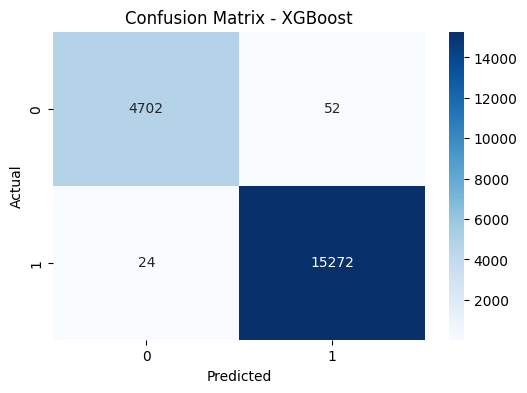

Random Forest - Accuracy: 0.9975, F1-Score: 0.9975


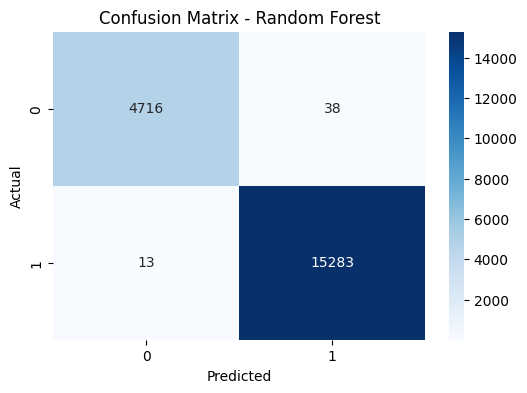

Decision Tree - Accuracy: 0.9955, F1-Score: 0.9955


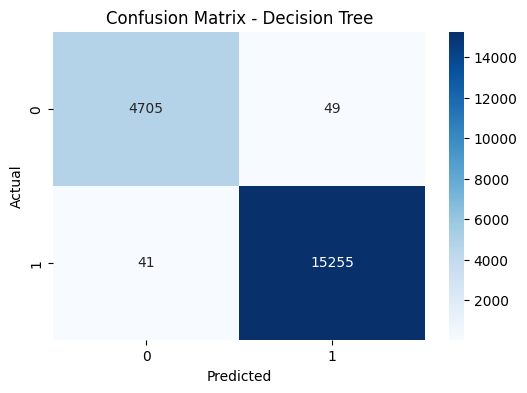

Bagging - Accuracy: 0.9963, F1-Score: 0.9963


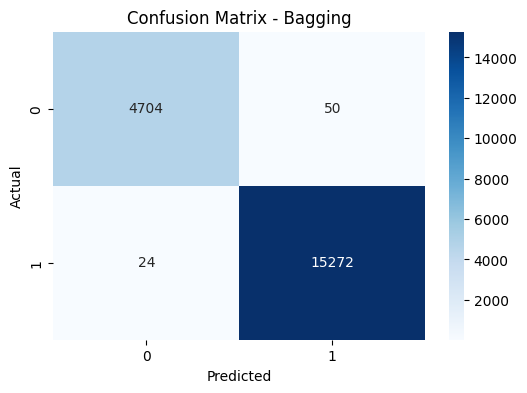

AdaBoost - Accuracy: 0.9837, F1-Score: 0.9837


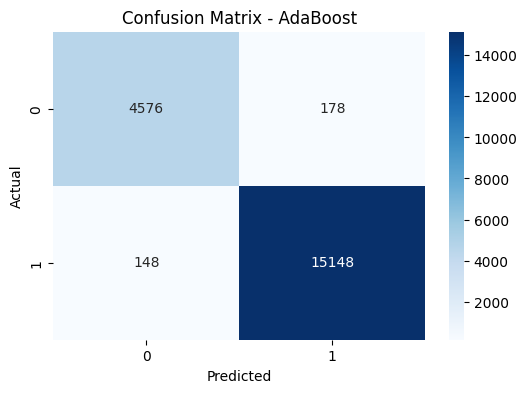


Teacher model evaluation on Unseen test data
           Model  Accuracy  F1-Score
0        XGBoost  0.996209  0.996206
1  Random Forest  0.997456  0.997454
2  Decision Tree  0.995511  0.995510
3        Bagging  0.996309  0.996306
4       AdaBoost  0.983741  0.983723

Starting training for student models...

 Cross validation results in student model training
   Student Model  Cross-Validation Accuracy
0        XGBoost                   0.999579
1  Random Forest                   0.999385
2  Decision Tree                   0.999257
3        Bagging                   0.999418
4       AdaBoost                   0.987364

Training complete for student models.
Starting evaluation on test dataset...


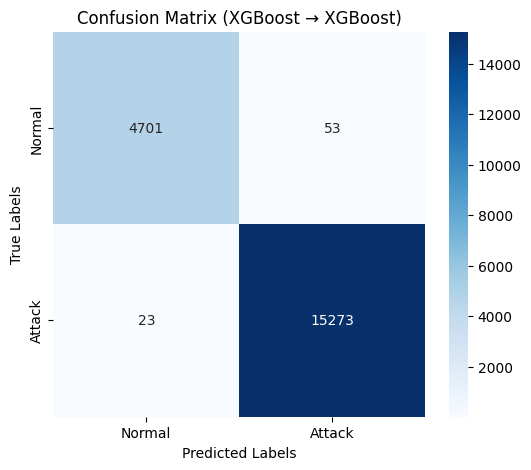

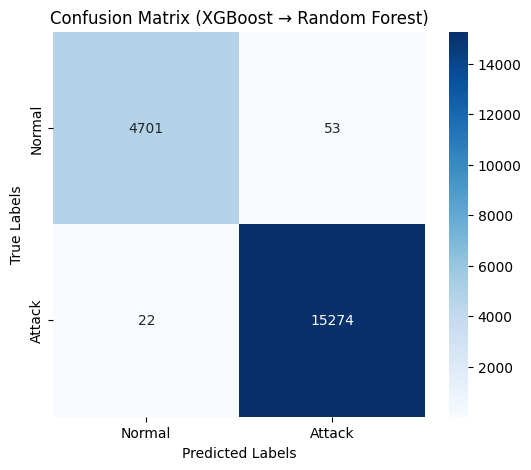

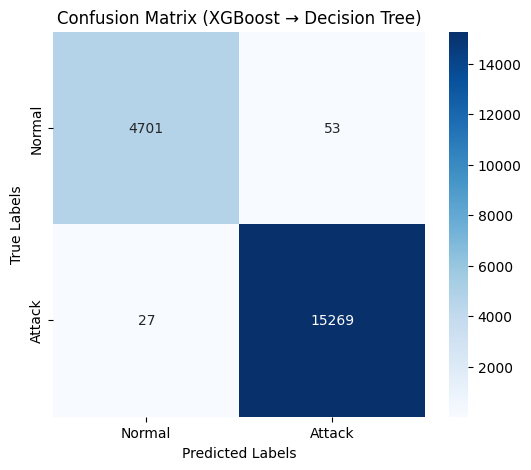

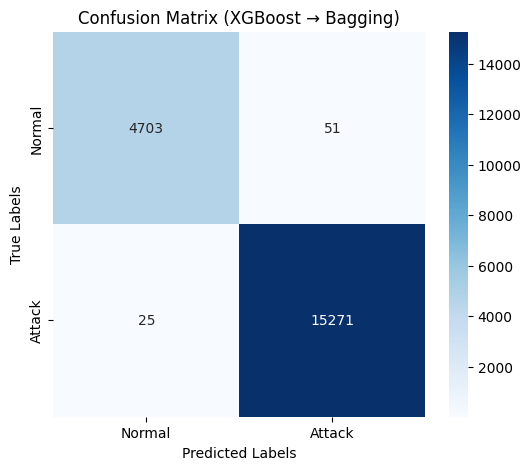

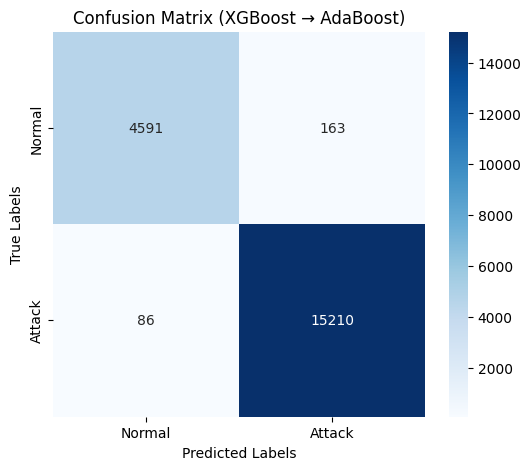


 Student model evaluation on unseen test data
  Teacher Model  Student Model  Test Accuracy  F1-Score
0       XGBoost        XGBoost       0.996209  0.996205
1       XGBoost  Random Forest       0.996259  0.996255
2       XGBoost  Decision Tree       0.996010  0.996006
3       XGBoost        Bagging       0.996209  0.996206
4       XGBoost       AdaBoost       0.987581  0.987546

Evaluation complete for student models.
Results saved to results/student_model_results.csv!
Starting training for student models...

 Cross validation results in student model training
   Student Model  Cross-Validation Accuracy
0        XGBoost                   0.999740
1  Random Forest                   0.999778
2  Decision Tree                   0.999601
3        Bagging                   0.999701
4       AdaBoost                   0.987459

Training complete for student models.
Starting evaluation on test dataset...


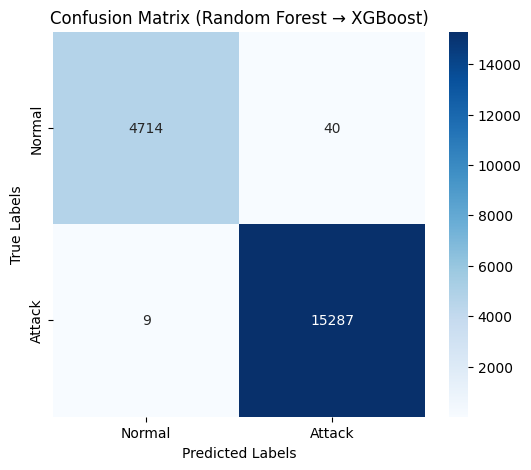

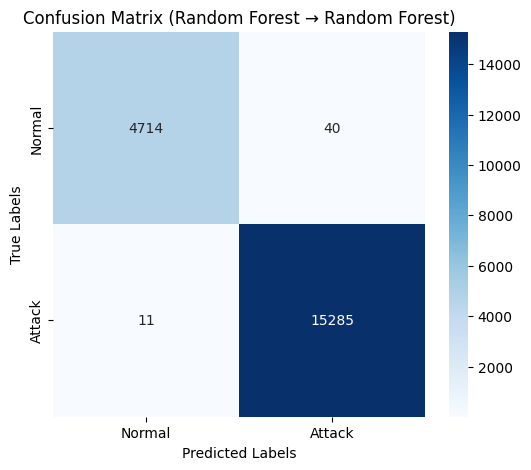

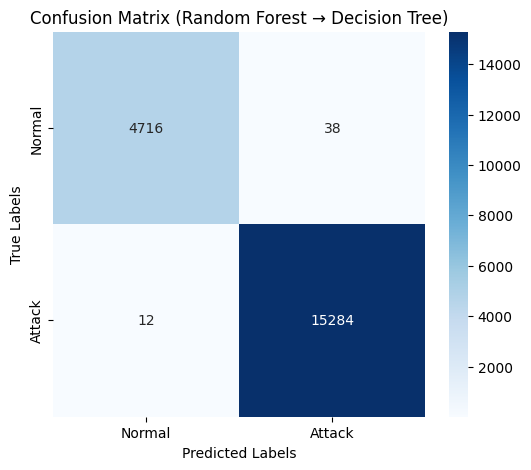

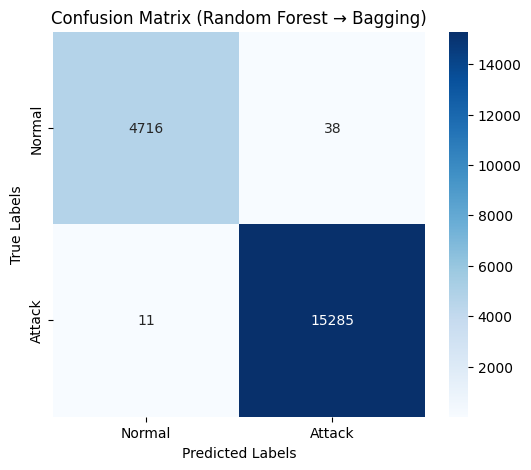

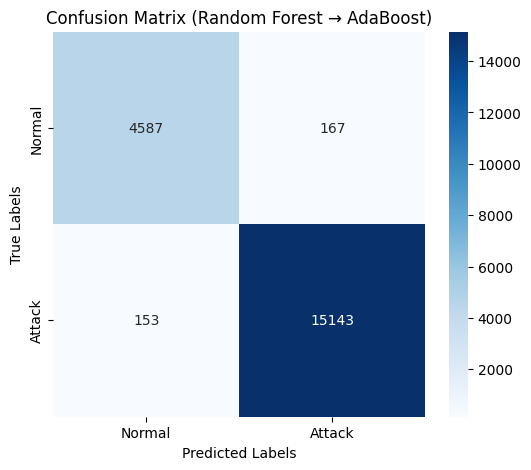


 Student model evaluation on unseen test data
   Teacher Model  Student Model  Test Accuracy  F1-Score
0  Random Forest        XGBoost       0.997556  0.997553
1  Random Forest  Random Forest       0.997456  0.997454
2  Random Forest  Decision Tree       0.997506  0.997504
3  Random Forest        Bagging       0.997556  0.997554
4  Random Forest       AdaBoost       0.984040  0.984032

Evaluation complete for student models.
Results saved to results/student_model_results.csv!
Starting training for student models...

 Cross validation results in student model training
   Student Model  Cross-Validation Accuracy
0        XGBoost                   0.999518
1  Random Forest                   0.999352
2  Decision Tree                   0.999762
3        Bagging                   0.999817
4       AdaBoost                   0.984859

Training complete for student models.
Starting evaluation on test dataset...


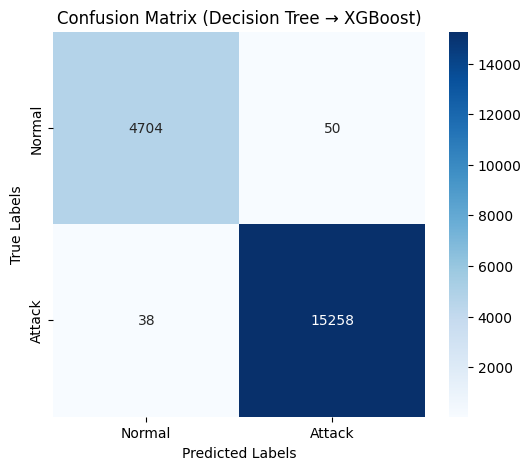

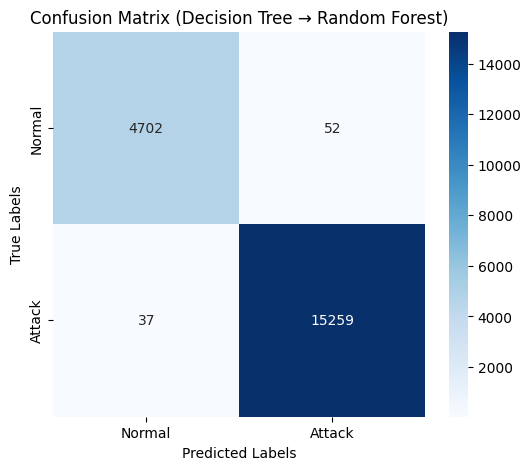

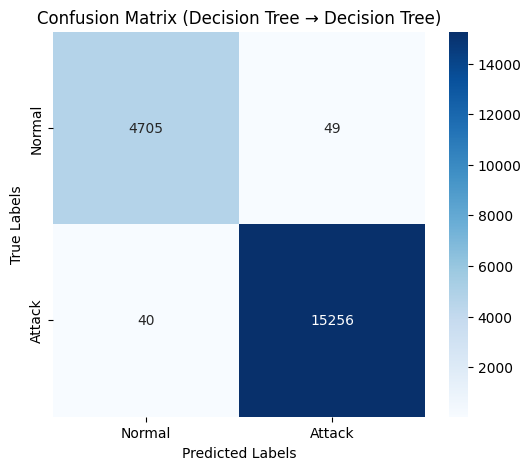

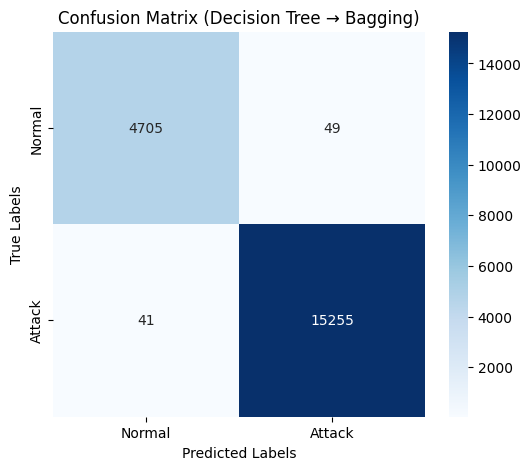

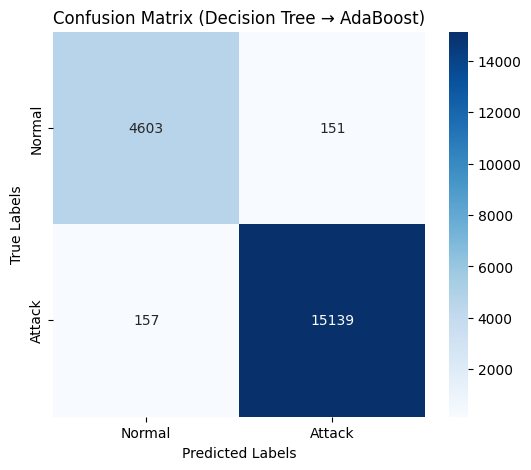


 Student model evaluation on unseen test data
   Teacher Model  Student Model  Test Accuracy  F1-Score
0  Decision Tree        XGBoost       0.995611  0.995609
1  Decision Tree  Random Forest       0.995561  0.995559
2  Decision Tree  Decision Tree       0.995561  0.995560
3  Decision Tree        Bagging       0.995511  0.995510
4  Decision Tree       AdaBoost       0.984638  0.984642

Evaluation complete for student models.
Results saved to results/student_model_results.csv!
Starting training for student models...

 Cross validation results in student model training
   Student Model  Cross-Validation Accuracy
0        XGBoost                   0.999607
1  Random Forest                   0.999485
2  Decision Tree                   0.999662
3        Bagging                   0.999728
4       AdaBoost                   0.987630

Training complete for student models.
Starting evaluation on test dataset...


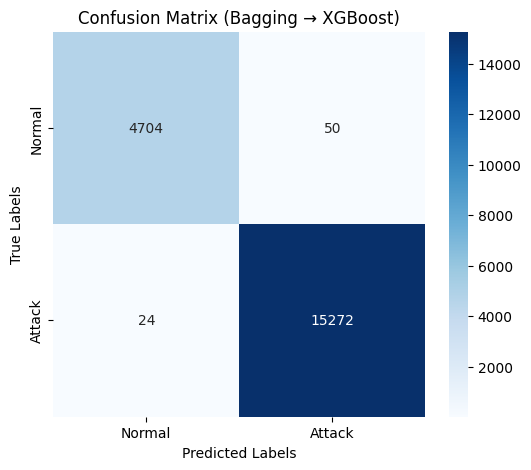

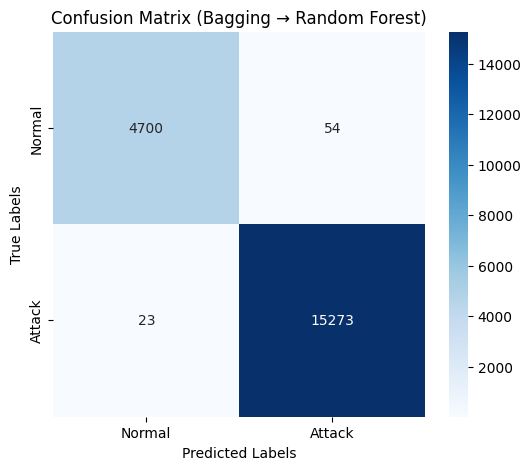

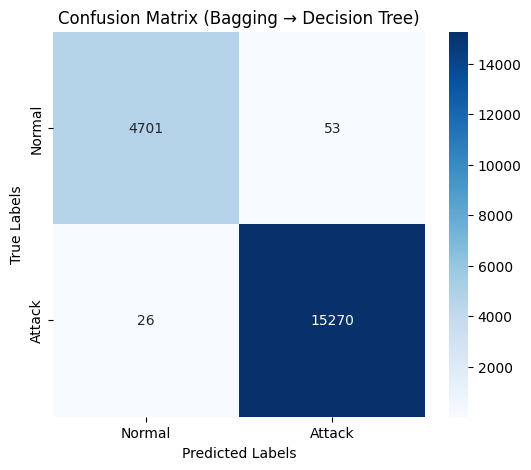

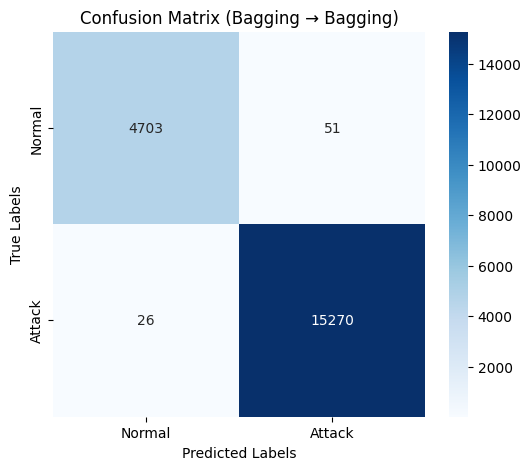

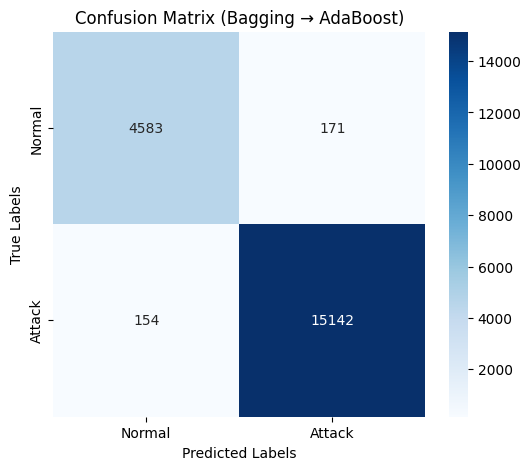


 Student model evaluation on unseen test data
  Teacher Model  Student Model  Test Accuracy  F1-Score
0       Bagging        XGBoost       0.996309  0.996306
1       Bagging  Random Forest       0.996160  0.996155
2       Bagging  Decision Tree       0.996060  0.996056
3       Bagging        Bagging       0.996160  0.996156
4       Bagging       AdaBoost       0.983791  0.983781

Evaluation complete for student models.
Results saved to results/student_model_results.csv!
Starting training for student models...

 Cross validation results in student model training
   Student Model  Cross-Validation Accuracy
0        XGBoost                   0.999839
1  Random Forest                   0.999861
2  Decision Tree                   0.999867
3        Bagging                   0.999889
4       AdaBoost                   0.997839

Training complete for student models.
Starting evaluation on test dataset...


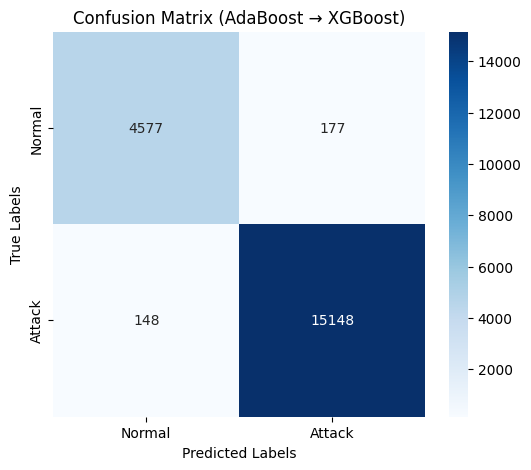

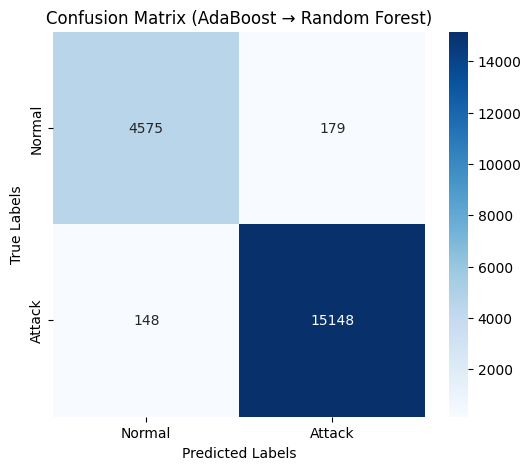

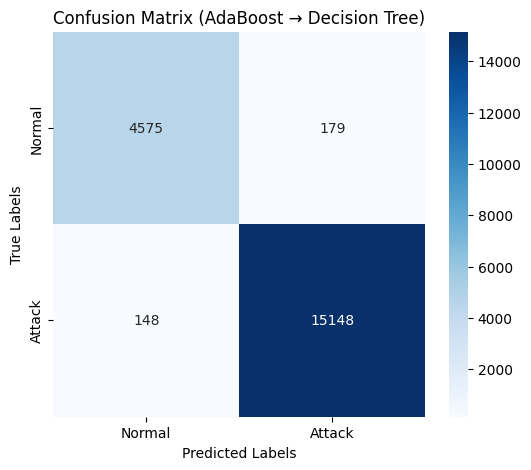

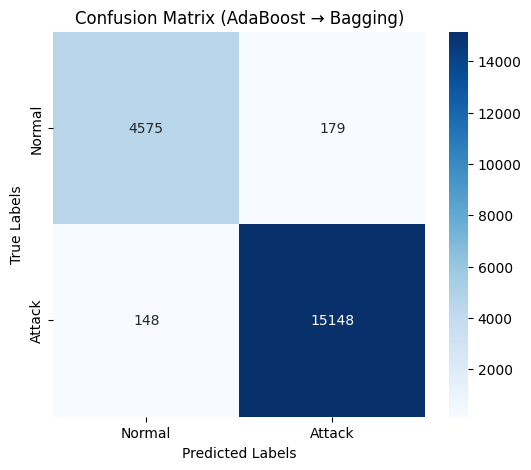

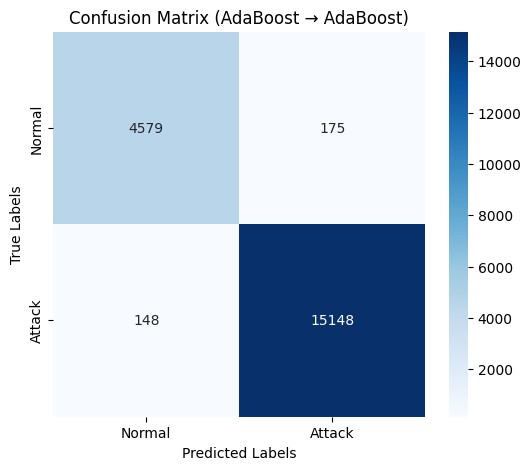


 Student model evaluation on unseen test data
  Teacher Model  Student Model  Test Accuracy  F1-Score
0      AdaBoost        XGBoost       0.983791  0.983773
1      AdaBoost  Random Forest       0.983691  0.983672
2      AdaBoost  Decision Tree       0.983691  0.983672
3      AdaBoost        Bagging       0.983691  0.983672
4      AdaBoost       AdaBoost       0.983890  0.983874

Evaluation complete for student models.
Results saved to results/student_model_results.csv!

========== Supervised Learning: Train_Test_IoT_WeatherNormalAttackP.csv ==========
Dataset loaded successfully. Shape: (39260, 4)
Labeled: (1963, 4), Unlabeled: (37297, 4)
Unlabeled Train: (33567, 3), Test: (3730, 3)
supervised datasets saved successfully!
Labeled Train: (1570, 3), Validation: (393, 3)

 Cross validation results in teacher model training
           Model  Cross-Validation Accuracy
0        XGBoost                   0.798726
1  Random Forest                   0.822293
2  Decision Tree                  

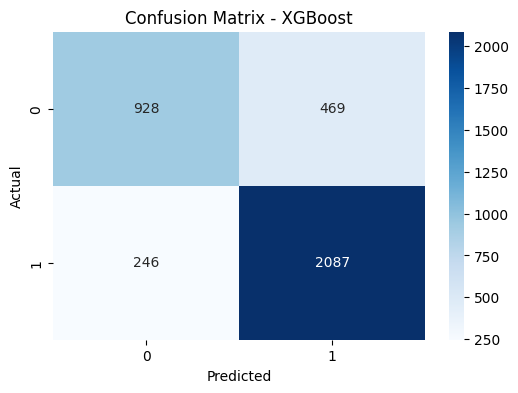

Random Forest - Accuracy: 0.8255, F1-Score: 0.8216


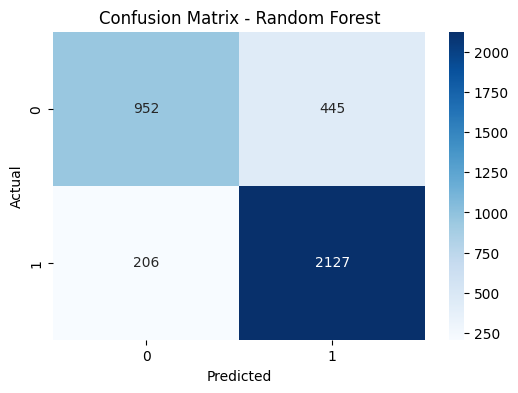

Decision Tree - Accuracy: 0.7727, F1-Score: 0.7717


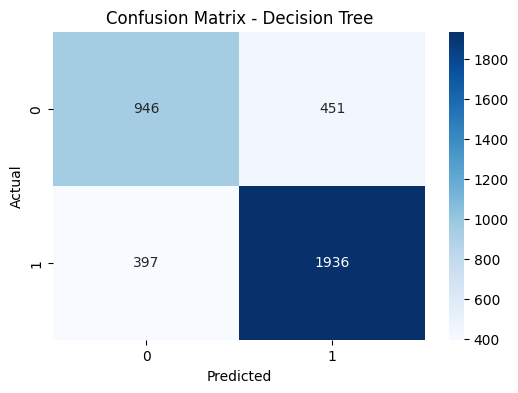

Bagging - Accuracy: 0.8228, F1-Score: 0.8197


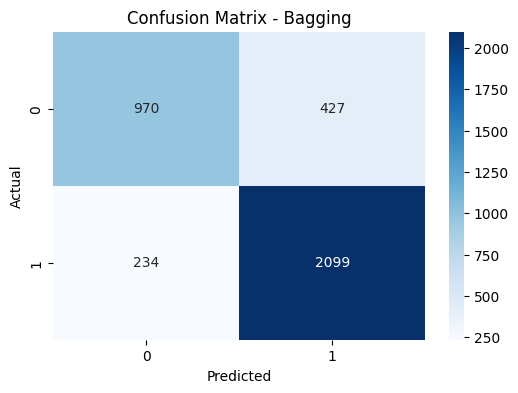

AdaBoost - Accuracy: 0.6984, F1-Score: 0.6773


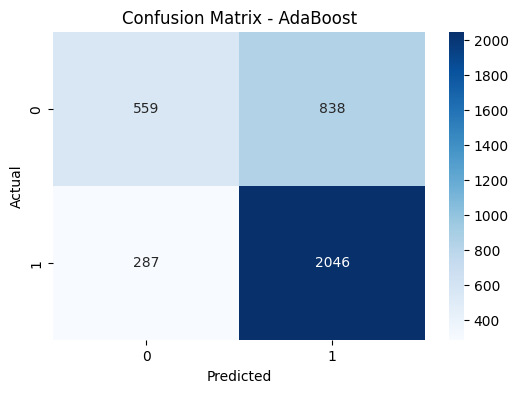


Teacher model evaluation on Unseen test data
           Model  Accuracy  F1-Score
0        XGBoost  0.808311  0.804369
1  Random Forest  0.825469  0.821558
2  Decision Tree  0.772654  0.771714
3        Bagging  0.822788  0.819733
4       AdaBoost  0.698391  0.677273

Starting training for student models...

 Cross validation results in student model training
   Student Model  Cross-Validation Accuracy
0        XGBoost                   0.962970
1  Random Forest                   0.974320
2  Decision Tree                   0.960705
3        Bagging                   0.969732
4       AdaBoost                   0.742366

Training complete for student models.
Starting evaluation on test dataset...


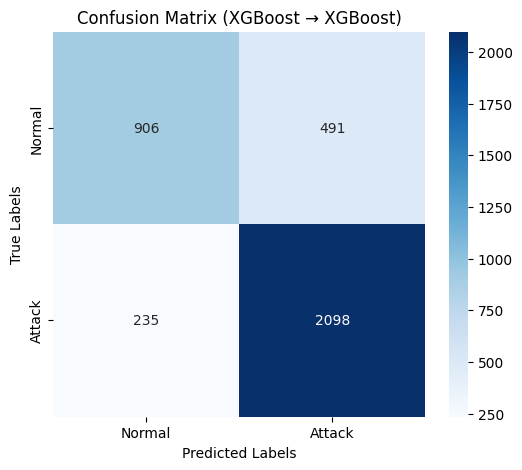

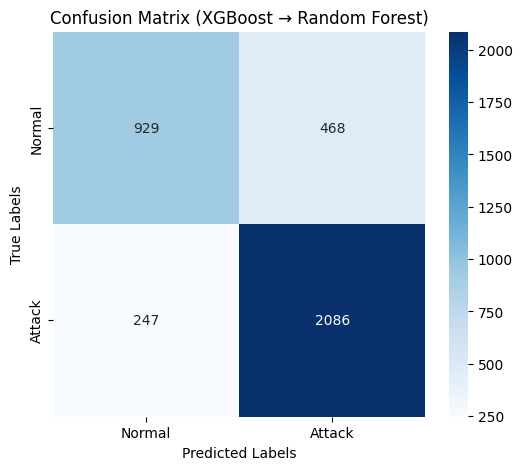

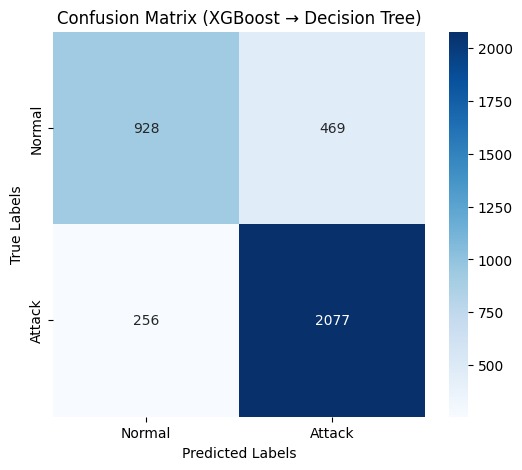

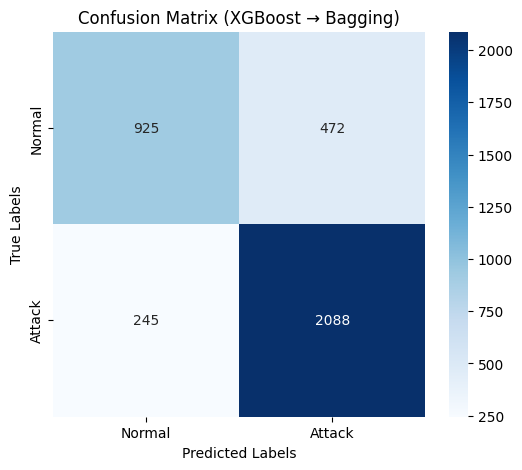

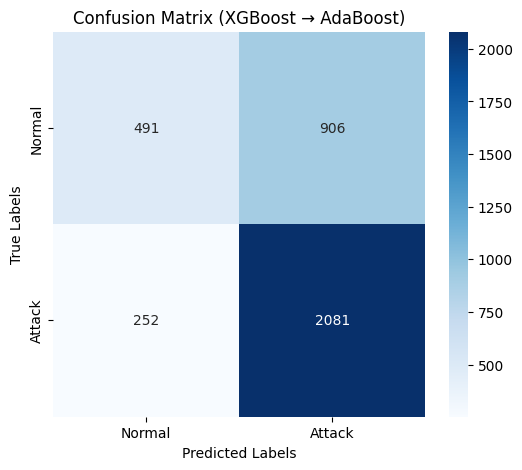


 Student model evaluation on unseen test data
  Teacher Model  Student Model  Test Accuracy  F1-Score
0       XGBoost        XGBoost       0.805362  0.800607
1       XGBoost  Random Forest       0.808311  0.804413
2       XGBoost  Decision Tree       0.805630  0.801852
3       XGBoost        Bagging       0.807775  0.803734
4       XGBoost       AdaBoost       0.689544  0.661188

Evaluation complete for student models.
Results saved to results/student_model_results.csv!
Starting training for student models...

 Cross validation results in student model training
   Student Model  Cross-Validation Accuracy
0        XGBoost                   0.962671
1  Random Forest                   0.976882
2  Decision Tree                   0.966366
3        Bagging                   0.974052
4       AdaBoost                   0.765960

Training complete for student models.
Starting evaluation on test dataset...


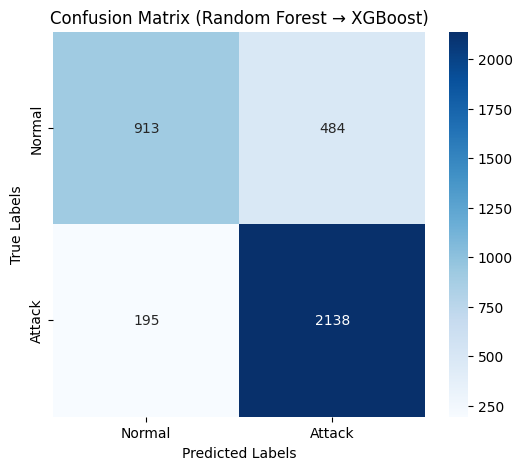

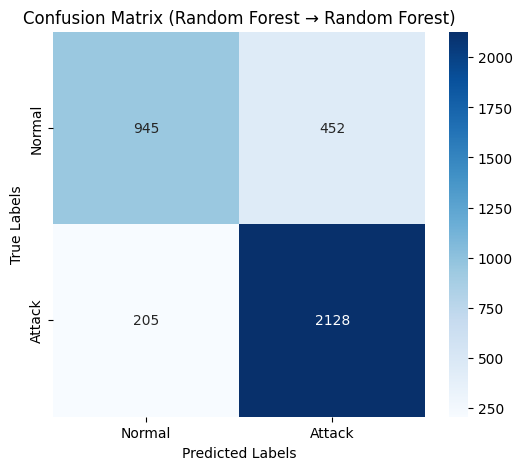

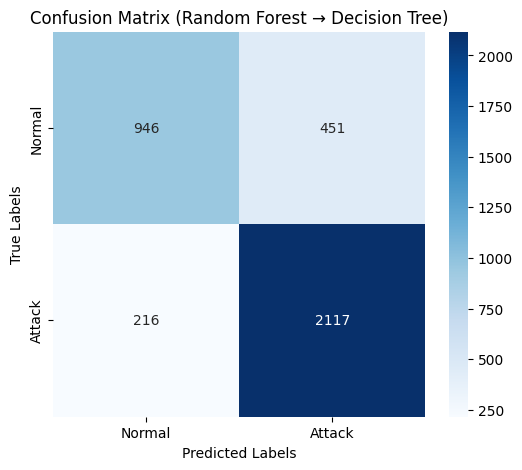

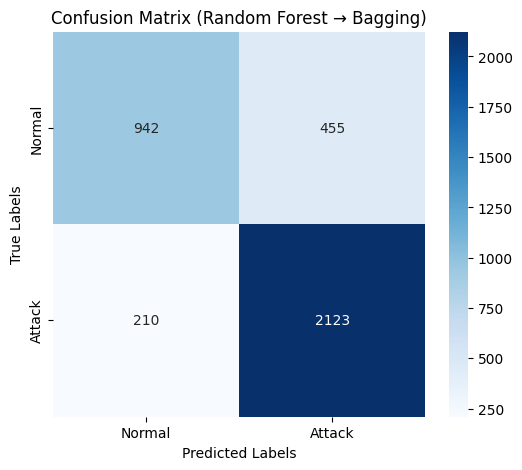

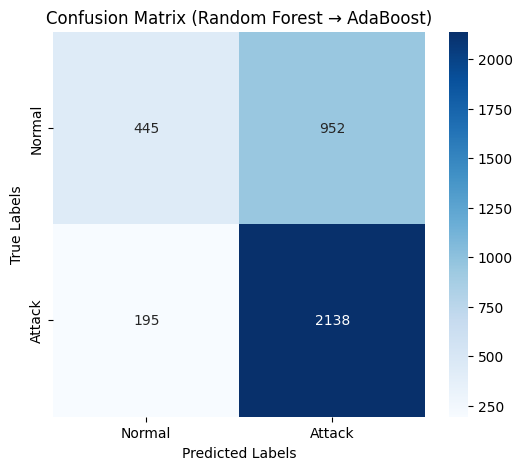


 Student model evaluation on unseen test data
   Teacher Model  Student Model  Test Accuracy  F1-Score
0  Random Forest        XGBoost       0.817962  0.812770
1  Random Forest  Random Forest       0.823861  0.819748
2  Random Forest  Decision Tree       0.821180  0.817256
3  Random Forest        Bagging       0.821716  0.817595
4  Random Forest       AdaBoost       0.692493  0.656817

Evaluation complete for student models.
Results saved to results/student_model_results.csv!
Starting training for student models...

 Cross validation results in student model training
   Student Model  Cross-Validation Accuracy
0        XGBoost                   0.962701
1  Random Forest                   0.985581
2  Decision Tree                   0.985849
3        Bagging                   0.990556
4       AdaBoost                   0.711444

Training complete for student models.
Starting evaluation on test dataset...


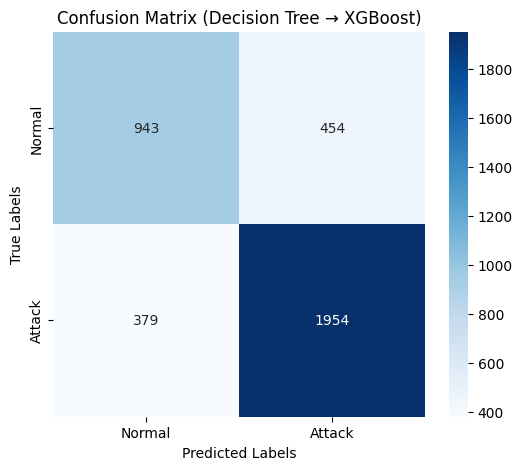

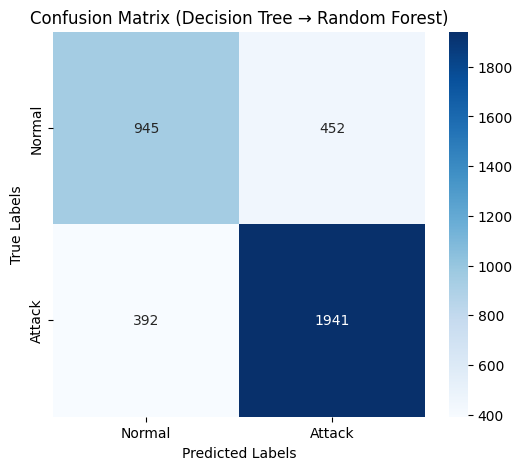

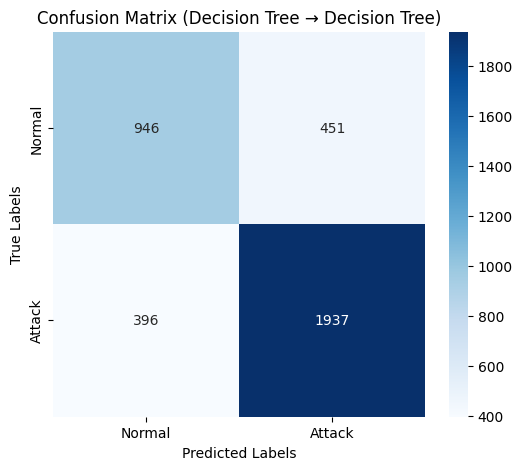

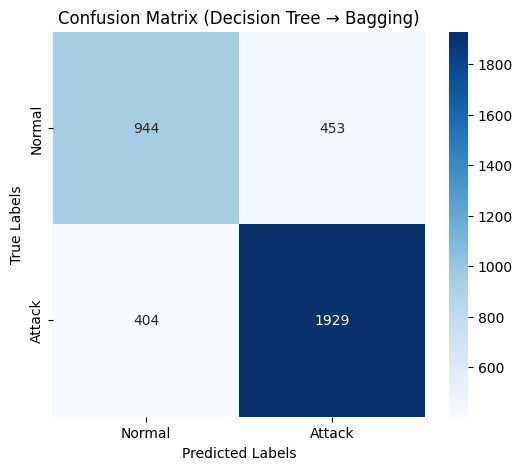

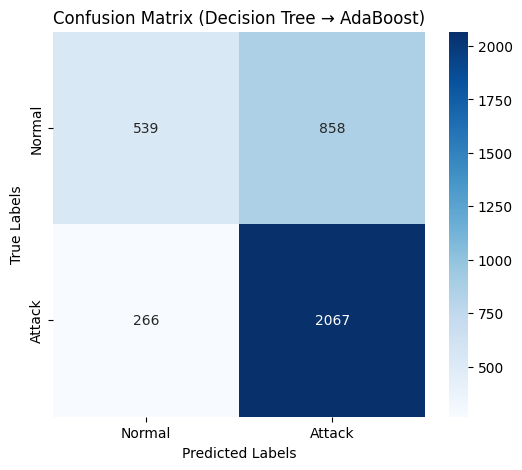


 Student model evaluation on unseen test data
   Teacher Model  Student Model  Test Accuracy  F1-Score
0  Decision Tree        XGBoost       0.776676  0.775362
1  Decision Tree  Random Forest       0.773727  0.772680
2  Decision Tree  Decision Tree       0.772922  0.771965
3  Decision Tree        Bagging       0.770241  0.769384
4  Decision Tree       AdaBoost       0.698660  0.675116

Evaluation complete for student models.
Results saved to results/student_model_results.csv!
Starting training for student models...

 Cross validation results in student model training
   Student Model  Cross-Validation Accuracy
0        XGBoost                   0.964340
1  Random Forest                   0.981589
2  Decision Tree                   0.972592
3        Bagging                   0.979087
4       AdaBoost                   0.765871

Training complete for student models.
Starting evaluation on test dataset...


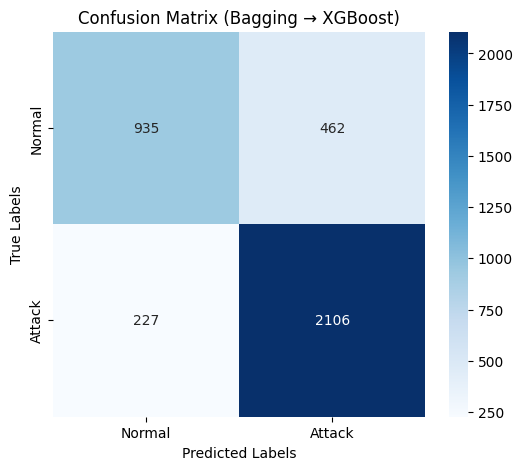

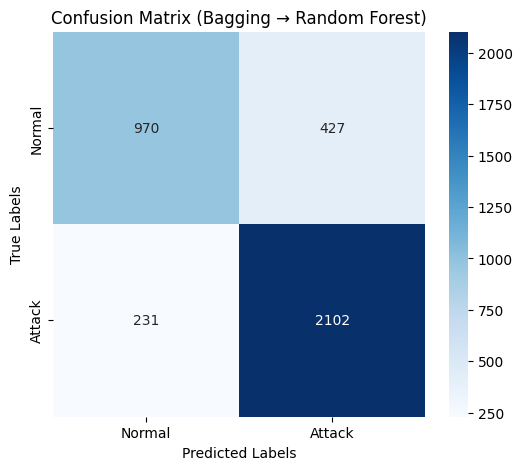

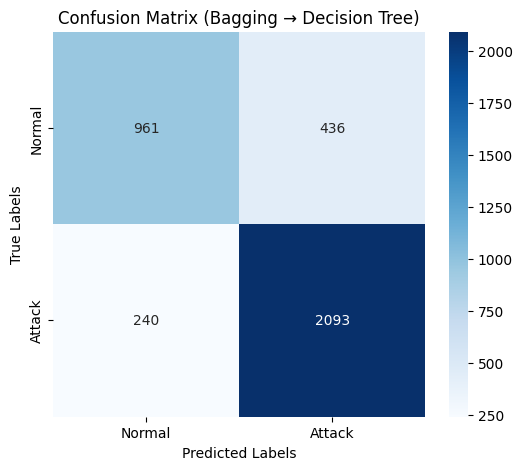

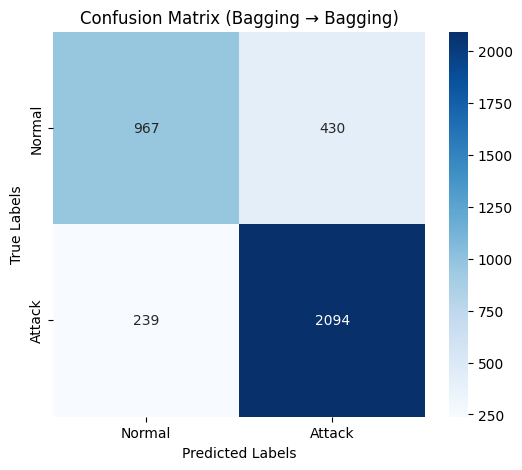

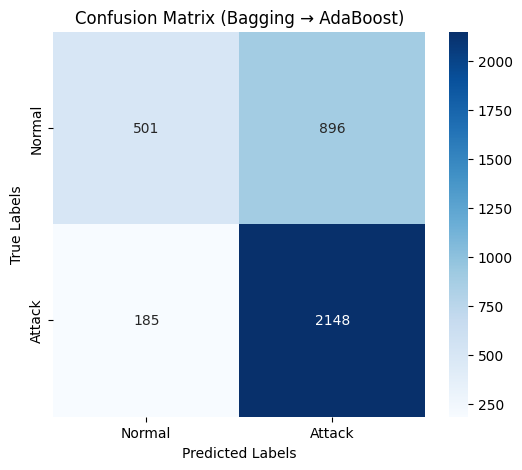


 Student model evaluation on unseen test data
  Teacher Model  Student Model  Test Accuracy  F1-Score
0       Bagging        XGBoost       0.815282  0.811228
1       Bagging  Random Forest       0.823592  0.820494
2       Bagging  Decision Tree       0.818767  0.815583
3       Bagging        Bagging       0.820643  0.817590
4       Bagging       AdaBoost       0.710188  0.679887

Evaluation complete for student models.
Results saved to results/student_model_results.csv!
Starting training for student models...

 Cross validation results in student model training
   Student Model  Cross-Validation Accuracy
0        XGBoost                   0.997676
1  Random Forest                   0.999315
2  Decision Tree                   0.999196
3        Bagging                   0.999345
4       AdaBoost                   0.983585

Training complete for student models.
Starting evaluation on test dataset...


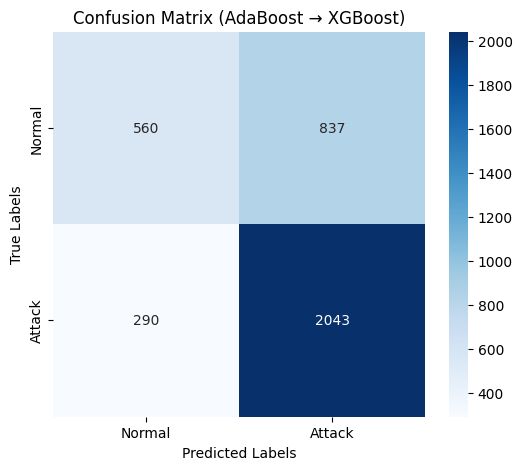

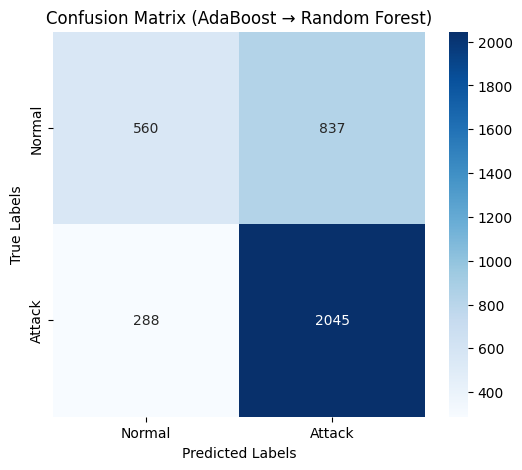

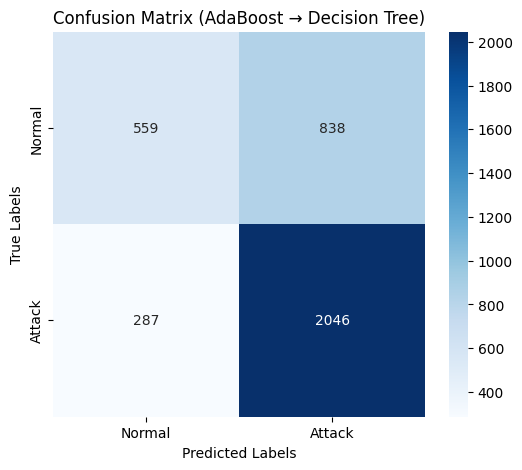

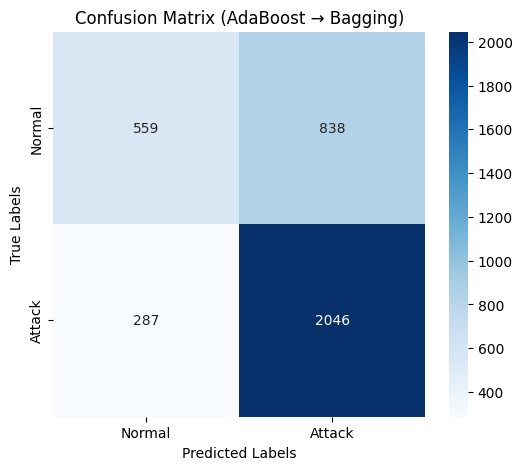

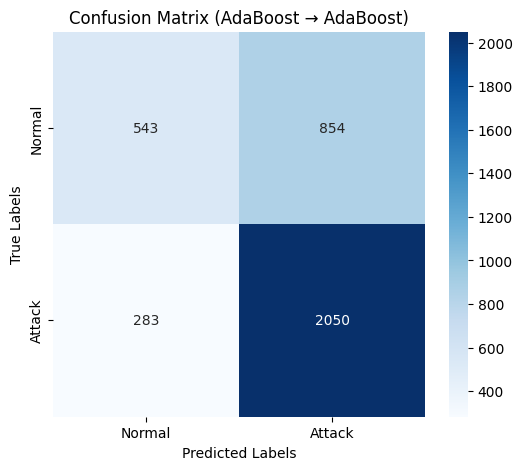


 Student model evaluation on unseen test data
  Teacher Model  Student Model  Test Accuracy  F1-Score
0      AdaBoost        XGBoost       0.697855  0.676931
1      AdaBoost  Random Forest       0.698391  0.677389
2      AdaBoost  Decision Tree       0.698391  0.677273
3      AdaBoost        Bagging       0.698391  0.677273
4      AdaBoost       AdaBoost       0.695174  0.672643

Evaluation complete for student models.
Results saved to results/student_model_results.csv!

========== Semi-Supervised Learning: train_test_networkP.csv ==========
Dataset loaded successfully. Shape: (211043, 31)
Normal: (50000, 31), Attack: (161043, 31)
Autoencoder Train: (10000, 30), Pseudo: (40000, 31)
Semi-Supervised Train: (180938, 30), Test: (20105, 30)
semi_supervised datasets saved successfully!
Training Autoencoder on Normal Data...
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1180
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0092
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━

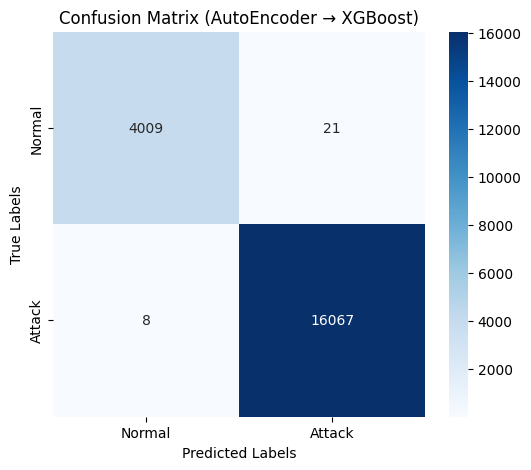

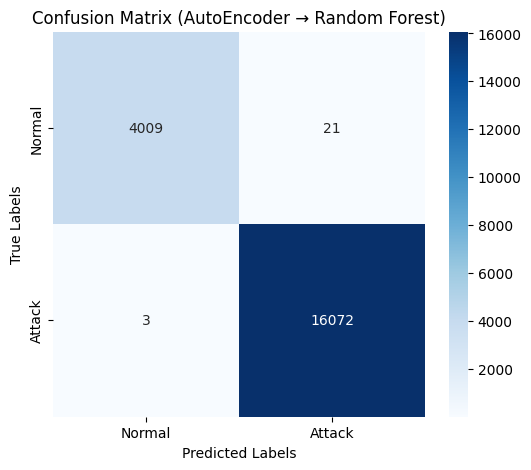

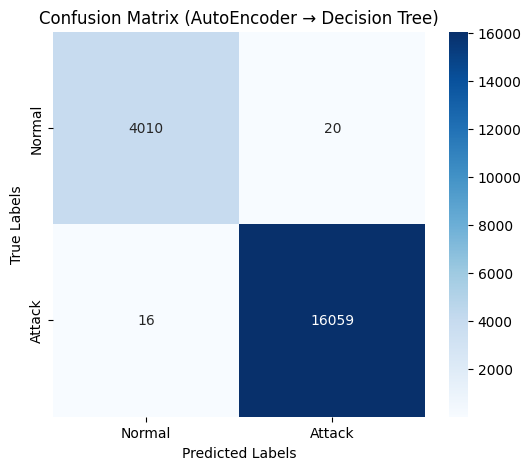

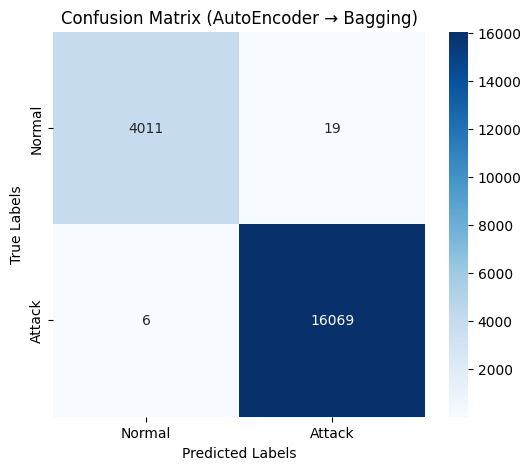

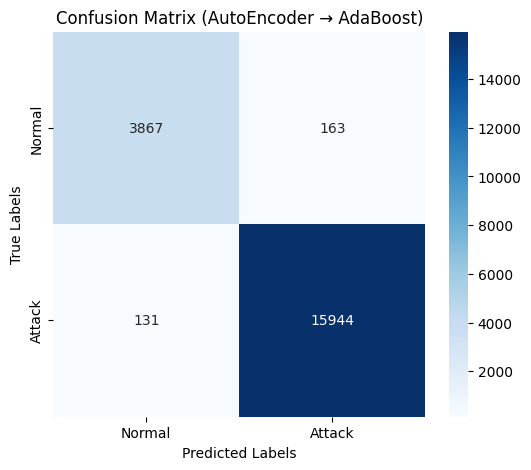


 Student model evaluation on unseen test data
  Teacher Model  Student Model  Test Accuracy  F1-Score
0   AutoEncoder        XGBoost       0.998558  0.998557
1   AutoEncoder  Random Forest       0.998806  0.998805
2   AutoEncoder  Decision Tree       0.998209  0.998209
3   AutoEncoder        Bagging       0.998757  0.998756
4   AutoEncoder       AdaBoost       0.985377  0.985355

Evaluation complete for student models.
Results saved to results/semi_supervised_student_results.csv!

========== Semi-Supervised Learning: Train_Test_IoT_WeatherNormalAttackP.csv ==========
Dataset loaded successfully. Shape: (39260, 4)
Normal: (15000, 4), Attack: (24260, 4)
Autoencoder Train: (3000, 3), Pseudo: (12000, 4)
Semi-Supervised Train: (32634, 3), Test: (3626, 3)
semi_supervised datasets saved successfully!
Training Autoencoder on Normal Data...
Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0658
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0472
Epoch 3/50
94/94 ━━━━━━━━

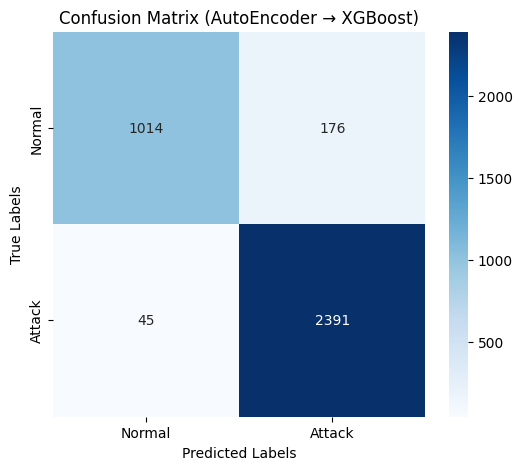

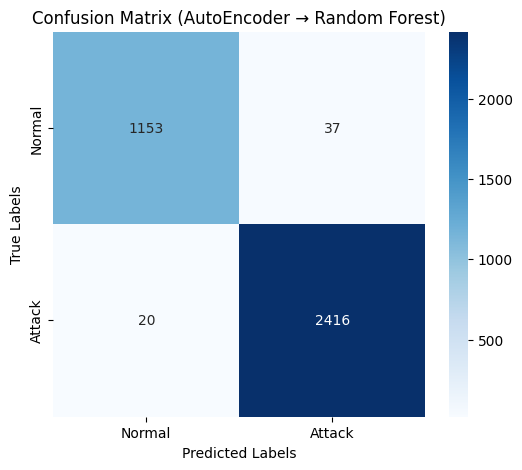

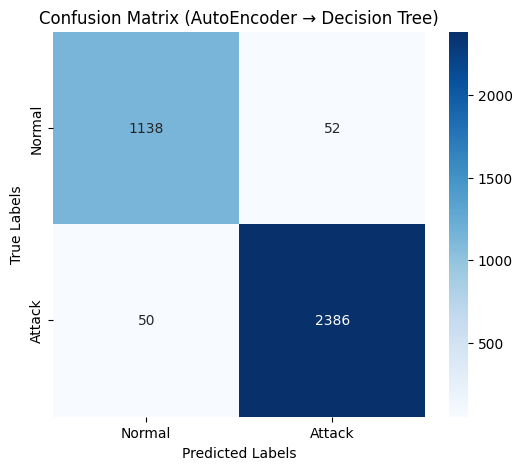

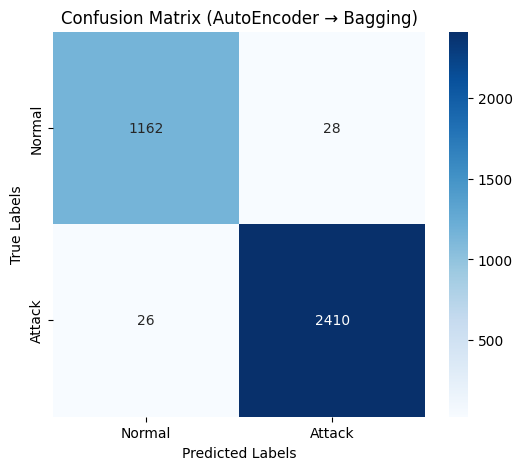

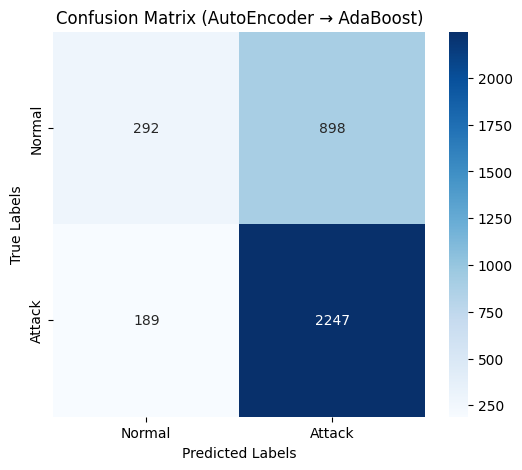


 Student model evaluation on unseen test data
  Teacher Model  Student Model  Test Accuracy  F1-Score
0   AutoEncoder        XGBoost       0.939051  0.938074
1   AutoEncoder  Random Forest       0.984280  0.984251
2   AutoEncoder  Decision Tree       0.971870  0.971864
3   AutoEncoder        Bagging       0.985108  0.985104
4   AutoEncoder       AdaBoost       0.700221  0.655665

Evaluation complete for student models.
Results saved to results/semi_supervised_student_results.csv!


In [ ]:
import pandas as pd
import os
# from data_handler import DataHandler
# from teacher_model import TeacherModel
# from student_model import StudentModel

def train_supervised(dataset_path):
    """ Supervised Learning Pipeline """
    print(f"\n========== Supervised Learning: {dataset_path} ==========")

    data_handler = DataHandler(dataset_path)
    data_handler.load_dataset()
    data_handler.split_labeled_unlabeled()
    data_handler.split_unlabeled_train_test()
    data_handler.save_datasets()

    X_train, X_val, y_train, y_val = data_handler.prepare_labeled_data_for_training()
    X_test, y_test = data_handler.unlabeled_test_df, data_handler.test_labels

    teacher = TeacherModel(X_train, y_train)
    teacher.train_with_cross_validation()  # Updated to separate training
    teacher.evaluate_models(X_test, y_test)  # Separate evaluation

    for teacher_model_name in teacher.trained_models.keys():
        pseudo_labels = teacher.generate_pseudo_labels(data_handler.unlabeled_train_df, teacher_model_name)
        pseudo_labels_series = pd.Series(pseudo_labels, name='pseudo_label')

        student_model = StudentModel(data_handler.unlabeled_train_df, pseudo_labels_series)
        student_model.train_models()  # Separate training
        student_model.evaluate_models(X_test, y_test, teacher_model_name)  # Separate evaluation
        student_model.save_results()

def train_semi_supervised(dataset_path):
    """ Semi-Supervised Learning Pipeline """
    print(f"\n========== Semi-Supervised Learning: {dataset_path} ==========")

    data_handler = DataHandler(dataset_path)
    data_handler.load_dataset()
    data_handler.split_normal_attack_data()
    data_handler.split_autoencoder_train_data()
    data_handler.prepare_semi_supervised_data()
    data_handler.save_datasets_semi_supervised()

    teacher = TeacherModel()
    teacher.train_autoencoder(data_handler.normal_train_df)

    pseudo_labels = teacher.generate_pseudo_labels_semi_supervised(data_handler.semi_supervised_train_df)
    pseudo_labels_df = pd.DataFrame(pseudo_labels, columns=["pseudo_label"])
    pseudo_labels_file = "pseudo_labeled_autoencoder.csv"
    pseudo_labels_df.to_csv(pseudo_labels_file, index=False)
    print("Pseudo-labels generated and saved for AutoEncoder.")

    if os.path.exists(pseudo_labels_file):
        student_model = StudentModel(data_handler.semi_supervised_train_df, data_handler.semi_supervised_train_labels)
        student_model.train_models()  # Separate training
        student_model.evaluate_models(data_handler.semi_supervised_test_df, data_handler.semi_supervised_test_labels, "AutoEncoder")  # Separate evaluation
        student_model.save_results(semi_supervised=True)

if __name__ == "__main__":
    # Run Supervised Learning on multiple datasets
    supervised_datasets = ["train_test_networkP.csv", "Train_Test_IoT_WeatherNormalAttackP.csv"]
    for dataset in supervised_datasets:
        train_supervised(dataset)

    # Run Semi-Supervised Learning
    train_semi_supervised("train_test_networkP.csv")
    train_semi_supervised("Train_Test_IoT_WeatherNormalAttackP.csv")
